In [1]:
# Import libraries and standardize path
import os
from pathlib import Path
import numpy as np
import cv2
from tkinter.filedialog import askopenfilename
import SimpleITK as sitk
import nibabel as nib

In [2]:
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")
# Change directory as needed

os.chdir("/Users/Jacks/Desktop/Jackson's Homework/Year 4/BMEG 457/MRI-TO-PCT/Capstone Code and resources")

Current working directory: d:\Users\Jacks\Desktop\Jackson's Homework\Year 4\BMEG 457\MRI-TO-PCT\Capstone Code and resources\Code


In [4]:
# Section for inverse log scaling + bias correction

image_path = "Images/presentationTestImage.png" # Change as needed

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Image at path '{image_path}' could not be loaded. Check the file path.")

image_sitk = sitk.GetImageFromArray(image)
image_sitk = sitk.Cast(image_sitk, sitk.sitkFloat32) # Need to cast to float to avoid uint8 errors

# Bias Field Correction (N4ITK)
corrector = sitk.N4BiasFieldCorrectionImageFilter()

# Degree of the B-spline used for bias correction (smoothness)
corrector.SetSplineOrder(2)  # 2 looks the best
# Determines when the correction stops
corrector.SetConvergenceThreshold(10 ** -3)  # 10^-3 or smaller is best
# Impacts the histogram size for intensity mapping
corrector.SetNumberOfHistogramBins(50) # best is i = 50
# Controls the number of iterations at each resolution level
corrector.SetMaximumNumberOfIterations([50, 50, 50, 50])  # best is standard -> i = 50

corrected_image_sitk = corrector.Execute(image_sitk)

corrected_image = sitk.GetArrayFromImage(corrected_image_sitk)
corrected_image = corrected_image / np.max(corrected_image) # Normalization from [0 - 1]

log_image = np.log(corrected_image + 1) # Avoids log(0)
log_image = np.uint8(255 * log_image)

inverse_log_image = 255 - log_image  
cv2.imwrite('CFP_inverse_log_scaled_image_presentation.png', inverse_log_image) # Change as needed to avoid overwrite

True

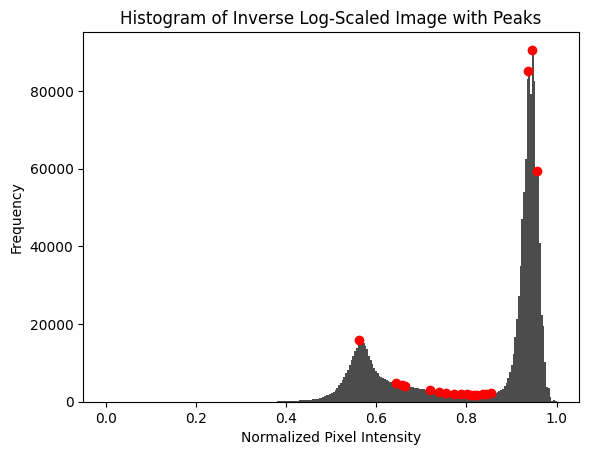

Thresholds for Peaks: [0.5625     0.64453125 0.65625    0.6640625  0.71875    0.73828125
 0.75390625 0.7734375  0.7890625  0.80078125 0.80859375 0.81640625
 0.82421875 0.8359375  0.84375    0.85546875 0.9375     0.9453125
 0.95703125]
Thresholds for Noise Peak 0.9453125
Thresholds for Signal Peak 0.9375


In [5]:
# Section for Histogram and Thresholding
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

inv_norm = inverse_log_image / 255.0

hist, bins = np.histogram(inv_norm.ravel(), bins=256, range=(0, 1))

#Change height to identify peaks 
peaks, _ = find_peaks(hist, height=700)

#Find the two tallest peaks, these will correspond to the signal and noise peaks
sorted = np.argsort(hist[peaks])[::-1]  
top_two_peaks = hist[peaks[sorted[:2]]]

peak_noise_index= sorted[0]
peak_signal_index = sorted[1]

# Threshold values
thresholds = bins[peaks]

plt.hist(inv_norm.ravel(), bins=256, range=(0, 1), color='black', alpha=0.7)
plt.scatter(thresholds, hist[peaks], color='red', zorder=5)
plt.title('Histogram of Inverse Log-Scaled Image with Peaks')
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

print('Thresholds for Peaks:', thresholds)
print('Thresholds for Noise Peak', bins[peaks[peak_noise_index]])
print('Thresholds for Signal Peak', bins[peaks[peak_signal_index]])

C:\Users\Jacks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_gaussian_mixture.py:826: RuntimeWarning: divide by zero encountered in log
  return np.log(self.weights_)


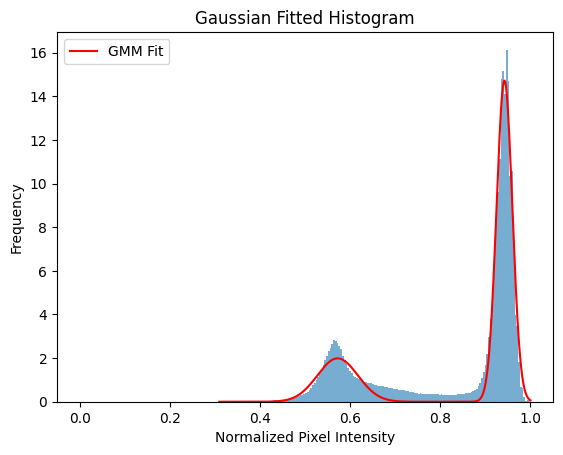

In [6]:
# Gaussian Fitting of Histogram
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=3 ,random_state=42) # ADDING THREE COMPONENTS SEEMS TO WORK BETTER
gmm.fit(inv_norm.ravel().reshape(-1, 1))

# Extract model parameters
means = gmm.means_.flatten()
std_devs = np.sqrt(gmm.covariances_).flatten()

# Sort means smallest to largest 
sorted_indices = np.argsort(means)
sorted_means = means[sorted_indices]
sorted_std_devs = std_devs[sorted_indices]

# Set the weight of the second peak to zero
gmm.weights_[sorted_indices[1]] = 0
#gmm.weights_[sorted_indices[2]] = 0
weights = gmm.weights_

# Plot histogram and fitted GMM
x = np.linspace(inv_norm.ravel().min(), inv_norm.ravel().max(), 1000)
pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))

plt.hist(inv_norm.ravel(), bins=256, density = True, range=(0, 1), alpha=0.6)
plt.plot(x, pdf, color='red', label="GMM Fit")
plt.title('Gaussian Fitted Histogram')
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()


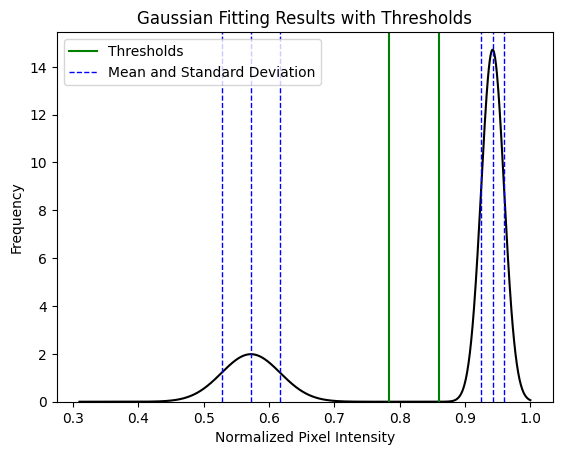

In [11]:
# Automatic Thresholding 
# Determine the signal and noise center
signal_center = sorted_means[0]
noise_center = sorted_means[2]

# FWHM = 2 * sqrt(2ln(2)) * σ where sigma is the standard deviation
signal_fwhm = 2*np.sqrt(2*np.log(2))*sorted_std_devs[0]
noise_fwhm = 2*np.sqrt(2*np.log(2))*sorted_std_devs[2]

# Select Thresholds [center(signal) + 2*FWHM(signal), center(noise)−2*FWHM(noise)]
lower_threshold = signal_center + 2*signal_fwhm
upper_threshold = noise_center - 2*noise_fwhm

# Plot histogram with thresholds 
plt.plot(x, pdf, color='black')
plt.title('Gaussian Fitting Results with Thresholds')
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('Frequency')
plt.ylim(bottom = 0)

# Add vertical lines
plt.axvline(x=lower_threshold, color='green', linestyle='-', label = 'Thresholds')
plt.axvline(x=upper_threshold, color='green', linestyle='-')
plt.axvline(x=signal_center, color='blue', linestyle='--', linewidth=1, label = 'Mean and Standard Deviation')
plt.axvline(x=noise_center, color='blue', linestyle='--', linewidth=1)
plt.axvline(x=signal_center + sorted_std_devs[0], color='blue', linestyle='--', linewidth=1)
plt.axvline(x=signal_center - sorted_std_devs[0], color='blue', linestyle='--', linewidth=1)
plt.axvline(x=noise_center + sorted_std_devs[2], color='blue', linestyle='--', linewidth=1)
plt.axvline(x=noise_center - sorted_std_devs[2], color='blue', linestyle='--', linewidth=1)
plt.legend()

plt.show()

In [8]:
# Select Thresholds [center(signal) + 2*FWHM(signal), center(noise)−2*FWHM(noise)]
lower_threshold = signal_center + 2*signal_fwhm
upper_threshold = noise_center - 2*noise_fwhm

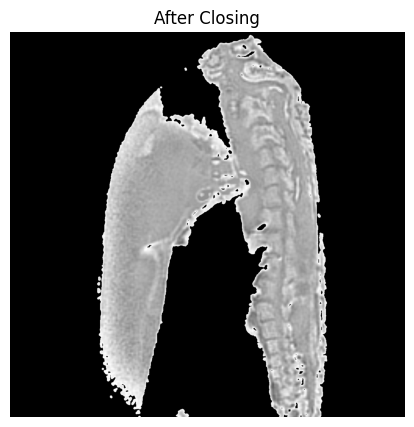

True

In [12]:
# Section for Segmentation based on Previous Thresholds
segmented_image = inverse_log_image

# Segment the image based on thresholds (masking from literature)
# NOTE: Masks may need to be switched around based on the DICOM pictures (i.e if bone is darker and background is lighter)
soft_tissue_mask = (inv_norm < lower_threshold) 
bone_mask = (inv_norm >= lower_threshold) & (inv_norm < upper_threshold)  
air_mask = (inv_norm >= upper_threshold) 

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))  # Adjust kernel size if needed


# Convert to binary image using bone_mask.astype(np.uint8) 
closed_soft_tissue_mask = cv2.morphologyEx(soft_tissue_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
closed_bone_mask = cv2.morphologyEx(bone_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
closed_air_mask = cv2.morphologyEx(air_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)


# Assign greyscale values for segment display
segmented_image[closed_air_mask == 1] = 0          # Air = Black
# segmented_image[closed_soft_tissue_mask] = 128  # Soft Tissue = Mid Grey (128)
# segmented_image[closed_bone_mask == 1] = 255       # Bone = White

# Display results
plt.figure(figsize=(10, 5))
plt.imshow(segmented_image, cmap="gray")
plt.title("After Closing")
plt.axis("off")

plt.show()

# Save results
cv2.imwrite('Closed_CFP_segmented_image_automatic_presentation.png', segmented_image)